In [102]:
import pandas as pd
import re
import jieba as jb
import tensorflow as tf
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import numpy as np

#from text_cleaner import remove
#from text_cleaner.processor.chinese import CHINESE, CHINESE_SYMBOLS_AND_PUNCTUATION



In [123]:
df = pd.read_csv(r'/Users/cairo/Google Drive/wechat data/ad data/AntzbBackData10k.csv', sep=',', error_bad_lines=False, index_col=False, dtype='unicode')

df=df[["account", 'advertisement','title', "content", "clicksCount", "orderNum", "originalFlag", "likeCount", "publicTime"]]

df[df.isnull().values==True]
df = df[pd.notnull(df['title'])]
df = df[pd.notnull(df['content'])]
df = df[pd.notnull(df['advertisement'])]

df["publicTime"] = pd.to_datetime(df["publicTime"])
#df["publicTime"] = dd["publicTime"].dt.to_period('D')
df["clicksCount"] = df["clicksCount"].astype(float)
df["likeCount"] = df["likeCount"].astype(float)
df["orderNum"] = df["orderNum"].astype(float)
df["originalFlag"] = df["originalFlag"].astype(float)

In [124]:
df['account'].nunique() 

944

In [22]:
df['advertisement'].value_counts()

C    6846
A    1935
B    1214
Name: advertisement, dtype: int64

In [29]:
#Text preprocessing

rule = re.compile(u"[^a-zA-Z0-9\u4E00-\u9FA5]")
def remove_punctuation(line):
    line = rule.sub('',str(line))
    return line


def stopwordslist(filepath):  
    stopwords = [line.strip() for line in open(filepath, 'r', encoding='utf-8').readlines()]  
    return stopwords  
 
#load the stopword file
stopwords = stopwordslist("/Users/cairo/Google Drive/wechat data/stopword.txt")



line = str(df["content"][0])
line

line.strip()

line.strip()==''

rule = re.compile(u"[^a-zA-Z0-9\u4E00-\u9FA5]")

line2 = rule.sub('',line)



In [30]:
# Clean title and content of the articles separately

df['clean_title'] = df['title'].map(lambda x: re.sub('\W+','', x))

df['clean_content'] = df['content'].map(lambda x: re.sub('\W+','', x))


df['cut_title'] = df['clean_title'].apply(lambda x: " ".join([w for w in list(jb.cut(x)) if w not in stopwords]))

df['cut_content'] = df['clean_content'].apply(lambda x: " ".join([w for w in list(jb.cut(x)) if w not in stopwords]))


#The combined text emphasized on the text in title by repeating it three times
df['combined_text'] = df['cut_title'] + df['cut_title'] + df['cut_title'] + df['cut_content']



In [69]:

MAX_NB_WORDS = 50000
# set max sequence length
MAX_SEQUENCE_LENGTH_title = 50
MAX_SEQUENCE_LENGTH_content = 500
# set Embeddingceng dimensions
EMBEDDING_DIM = 100 
tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words=MAX_NB_WORDS, filters='!"#$%&()*+,-./:;<=>?@[\]^_`{|}~', lower=True)

tokenizer.fit_on_texts(df['cut_title'].values)
word_index = tokenizer.word_index
print('There are %s unique words' % len(word_index))
X = tokenizer.texts_to_sequences(df['cut_title'].values)
X = tf.keras.preprocessing.sequence.pad_sequences(X, maxlen=MAX_SEQUENCE_LENGTH_title) #padding 


tokenizer.fit_on_texts(df['cut_content'].values)
word_index = tokenizer.word_index
print('There are %s unique words' % len(word_index))
X = tokenizer.texts_to_sequences(df['cut_content'].values)
X = tf.keras.preprocessing.sequence.pad_sequences(X, maxlen=MAX_SEQUENCE_LENGTH_content) 


tokenizer.fit_on_texts(df['combined_text'].values)
word_index = tokenizer.word_index
X = tokenizer.texts_to_sequences(df['combined_text'].values)
X = tf.keras.preprocessing.sequence.pad_sequences(X, maxlen=MAX_SEQUENCE_LENGTH_title + MAX_SEQUENCE_LENGTH_content)

 
#onehot coding the dependent variable
Y = pd.get_dummies(df['advertisement']).values
 
Y2 = df['likeCount'].values

print(X.shape)
print(Y.shape)

X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size = 0.20, random_state = 42)
#print(X_train.shape,Y_train.shape)
#print(X_test.shape,Y_test.shape)

X_train, X_test, Y2_train, Y2_test = train_test_split(X,Y2, test_size = 0.20, random_state = 42)

There are 23871 unique words
There are 310898 unique words
(9997, 550)
(9997, 3)


In [12]:
######## Models for ad classifcation 
#vanila LSTM 
model1 = tf.keras.Sequential()
model1.add(tf.keras.layers.Embedding(MAX_NB_WORDS, EMBEDDING_DIM, input_length=X.shape[1]))
model1.add(tf.keras.layers.LSTM(32, dropout=0.2, recurrent_dropout=0.2))  
model1.add(tf.keras.layers.Dense(3, activation='softmax'))
model1.compile(loss='categorical_crossentropy', optimizer='adam', metrics=[tf.keras.metrics.CategoricalAccuracy(), tf.keras.metrics.Precision(), tf.keras.metrics.Recall()])
print(model1.summary())

#bidirectional LSTM 
model2 = tf.keras.Sequential()
model2.add(tf.keras.layers.Embedding(MAX_NB_WORDS, EMBEDDING_DIM, input_length=X.shape[1]))
model2.add(tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(100, dropout=0.2, recurrent_dropout=0.2)))
model2.add(tf.keras.layers.Dense(3, activation='softmax'))
model2.compile(loss='categorical_crossentropy', optimizer='adam', metrics=[tf.keras.metrics.CategoricalAccuracy(), tf.keras.metrics.Precision(), tf.keras.metrics.Recall()])
print(model2.summary())


#stack two LSTM together
model3 = tf.keras.Sequential()
model3.add(tf.keras.layers.Embedding(MAX_NB_WORDS, EMBEDDING_DIM, input_length=X.shape[1]))
model3.add(tf.keras.layers.LSTM(32, dropout=0.2, recurrent_dropout=0.2, return_sequences=True))  
model3.add(tf.keras.layers.LSTM(32))
model3.add(tf.keras.layers.Dense(3, activation='softmax'))
model3.compile(loss='categorical_crossentropy', optimizer='adam', metrics=[tf.keras.metrics.CategoricalAccuracy(), tf.keras.metrics.Precision(), tf.keras.metrics.Recall()])
print(model3.summary())


Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 550, 100)          5000000   
_________________________________________________________________
lstm_4 (LSTM)                (None, 32)                17024     
_________________________________________________________________
dense_3 (Dense)              (None, 3)                 99        
Total params: 5,017,123
Trainable params: 5,017,123
Non-trainable params: 0
_________________________________________________________________
None
Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, 550, 100)          5000000   
_________________________________________________________________
bidirectional_1 (Bidirection (None, 200)               160800    
_________________

In [19]:
#########
epochs = 20
batch_size = 64
 
history1 = model1.fit(X, Y, epochs=epochs, batch_size=batch_size,validation_split=0.2, shuffle=True,
                    callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=2, min_delta=0.000001)])

history2 = model2.fit(X, Y, epochs=epochs, batch_size=batch_size,validation_split=0.2, shuffle=True,
                    callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=2, min_delta=0.000001)])

history3 = model3.fit(X, Y, epochs=epochs, batch_size=batch_size,validation_split=0.2, shuffle=True,
                    callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=2, min_delta=0.000001)])

#history = model.fit(X_train, Y_train, epochs=epochs, batch_size=batch_size,validation_split=0.2, shuffle=True)


Epoch 1/20
125/125 [==============================] - 90s 716ms/step - loss: 0.0470 - categorical_accuracy: 0.9845 - precision_3: 0.9863 - recall_3: 0.9840 - val_loss: 0.7679 - val_categorical_accuracy: 0.7970 - val_precision_3: 0.8053 - val_recall_3: 0.7908
Epoch 2/20
125/125 [==============================] - 105s 830ms/step - loss: 0.0354 - categorical_accuracy: 0.9886 - precision_3: 0.9897 - recall_3: 0.9871 - val_loss: 0.7953 - val_categorical_accuracy: 0.8095 - val_precision_3: 0.8114 - val_recall_3: 0.8033
Epoch 3/20
125/125 [==============================] - 64s 508ms/step - loss: 0.0273 - categorical_accuracy: 0.9914 - precision_3: 0.9921 - recall_3: 0.9909 - val_loss: 0.8015 - val_categorical_accuracy: 0.8005 - val_precision_3: 0.8079 - val_recall_3: 0.7958
Epoch 1/20
125/125 [==============================] - 199s 2s/step - loss: 0.0194 - categorical_accuracy: 0.9939 - precision_4: 0.9940 - recall_4: 0.9935 - val_loss: 0.8965 - val_categorical_accuracy: 0.8060 - val_precisio

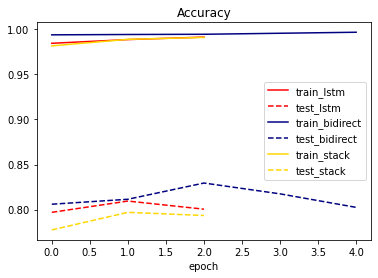

In [56]:

plt.title('Accuracy')
plt.xlabel('epoch')
plt.plot(history1.history['categorical_accuracy'], label='train_lstm', color = "red")
plt.plot(history1.history['val_categorical_accuracy'], label='test_lstm', linestyle='--', color = "red")
plt.plot(history2.history['categorical_accuracy'], label='train_bidirect', color = "navy")
plt.plot(history2.history['val_categorical_accuracy'], label='test_bidirect', linestyle='--', color = "navy")
plt.plot(history3.history['categorical_accuracy'], label='train_stack', color = "gold")
plt.plot(history3.history['val_categorical_accuracy'], label='test_stack', linestyle='--', color = "gold")
plt.legend()
plt.show()



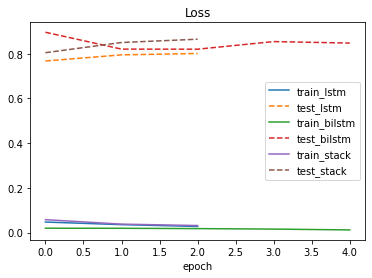

In [21]:
plt.title('Loss')
plt.xlabel('epoch')
plt.plot(history1.history['loss'], label='train_lstm', color = "red")
plt.plot(history1.history['val_loss'], label='test_lstm', linestyle='--', color = "red")
plt.plot(history2.history['loss'], label='train_bilstm', color = "navy")
plt.plot(history2.history['val_loss'], label='test_bilstm', linestyle='--', color = "navy")
plt.plot(history3.history['loss'], label='train_stack', color = "gold")
plt.plot(history3.history['val_loss'], label='test_stack', linestyle='--', color = "gold")
plt.legend()
plt.show()

In [ ]:

plt.title('Recall')
plt.plot(history1.history['recall_6'], label='train')
plt.plot(history1.history['val_recall_6'], label='test')
plt.legend()
plt.show()

plt.title('Precision')
plt.plot(history1.history['precision_6'], label='train')
plt.plot(history1.history['val_precision_6'], label='test')
plt.legend()
plt.show()

In [46]:
######## Models for regression
#vanila LSTM 
model1a = tf.keras.Sequential()
model1a.add(tf.keras.layers.Embedding(MAX_NB_WORDS, EMBEDDING_DIM, input_length=X.shape[1]))
model1a.add(tf.keras.layers.LSTM(32, dropout=0.2, recurrent_dropout=0.2))  
model1a.add(tf.keras.layers.Dense(1))
model1a.compile(loss='mean_squared_error', optimizer='adam', metrics=[tf.keras.metrics.MeanAbsolutePercentageError(),tf.keras.metrics.MeanSquaredError()])
print(model1a.summary())

#bidirectional LSTM 
model2a = tf.keras.Sequential()
model2a.add(tf.keras.layers.Embedding(MAX_NB_WORDS, EMBEDDING_DIM, input_length=X.shape[1]))
model2a.add(tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(100, dropout=0.2, recurrent_dropout=0.2)))
model2a.add(tf.keras.layers.Dense(1))
model2a.compile(loss='mean_squared_error', optimizer='adam', metrics=[tf.keras.metrics.MeanAbsolutePercentageError(),tf.keras.metrics.MeanSquaredError()])
print(model2a.summary())


#stack two LSTM together
model3a = tf.keras.Sequential()
model3a.add(tf.keras.layers.Embedding(MAX_NB_WORDS, EMBEDDING_DIM, input_length=X.shape[1]))
model3a.add(tf.keras.layers.LSTM(32, dropout=0.2, recurrent_dropout=0.2, return_sequences=True))  
model3a.add(tf.keras.layers.LSTM(32))
model3a.add(tf.keras.layers.Dense(1))
model3a.compile(loss='mean_squared_error', optimizer='adam', metrics=[tf.keras.metrics.MeanAbsolutePercentageError(),tf.keras.metrics.MeanSquaredError()])
print(model3a.summary())



Model: "sequential_21"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_21 (Embedding)     (None, 550, 100)          5000000   
_________________________________________________________________
lstm_28 (LSTM)               (None, 32)                17024     
_________________________________________________________________
dense_21 (Dense)             (None, 1)                 33        
Total params: 5,017,057
Trainable params: 5,017,057
Non-trainable params: 0
_________________________________________________________________
None
Model: "sequential_22"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_22 (Embedding)     (None, 550, 100)          5000000   
_________________________________________________________________
bidirectional_7 (Bidirection (None, 200)               160800    
_______________

In [70]:
#########
epochs = 20
batch_size = 64
 
history1a = model1a.fit(X, Y2, epochs=epochs, batch_size=batch_size,validation_split=0.2, shuffle=True,
                    callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=2, min_delta=0.000001)])

history2a = model2a.fit(X, Y2, epochs=epochs, batch_size=batch_size,validation_split=0.2, shuffle=True,
                    callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=2, min_delta=0.000001)])

history3a = model3a.fit(X, Y2, epochs=epochs, batch_size=batch_size,validation_split=0.2, shuffle=True,
                    callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=2, min_delta=0.000001)])



Epoch 1/20
125/125 [==============================] - 71s 516ms/step - loss: 995619.1875 - mean_absolute_percentage_error: 169764160.0000 - mean_squared_error: 995619.1875 - val_loss: 801982.9375 - val_mean_absolute_percentage_error: 251628896.0000 - val_mean_squared_error: 801982.9375
Epoch 2/20
125/125 [==============================] - 63s 507ms/step - loss: 990514.5000 - mean_absolute_percentage_error: 310614240.0000 - mean_squared_error: 990514.5000 - val_loss: 798229.4375 - val_mean_absolute_percentage_error: 348431776.0000 - val_mean_squared_error: 798229.4375
Epoch 3/20
125/125 [==============================] - 64s 508ms/step - loss: 987226.8750 - mean_absolute_percentage_error: 399142176.0000 - mean_squared_error: 987226.8750 - val_loss: 795191.6875 - val_mean_absolute_percentage_error: 428380192.0000 - val_mean_squared_error: 795191.6875
Epoch 4/20
125/125 [==============================] - 65s 520ms/step - loss: 984486.3125 - mean_absolute_percentage_error: 471008512.0000 -

125/125 [==============================] - 215s 2s/step - loss: 886103.7500 - mean_absolute_percentage_error: 1944836224.0000 - mean_squared_error: 886103.7500 - val_loss: 714392.1250 - val_mean_absolute_percentage_error: 2228860416.0000 - val_mean_squared_error: 714392.1250
Epoch 10/20
125/125 [==============================] - 239s 2s/step - loss: 878934.3750 - mean_absolute_percentage_error: 1969614080.0000 - mean_squared_error: 878934.3750 - val_loss: 724824.2500 - val_mean_absolute_percentage_error: 2008506112.0000 - val_mean_squared_error: 724824.2500
Epoch 11/20
125/125 [==============================] - 304s 2s/step - loss: 873268.0625 - mean_absolute_percentage_error: 2091314176.0000 - mean_squared_error: 873268.0625 - val_loss: 708983.1250 - val_mean_absolute_percentage_error: 2439692800.0000 - val_mean_squared_error: 708983.1250
Epoch 12/20
125/125 [==============================] - 384s 3s/step - loss: 866292.3125 - mean_absolute_percentage_error: 2056521600.0000 - mean_squ

125/125 [==============================] - 104s 829ms/step - loss: 958477.9375 - mean_absolute_percentage_error: 1096582784.0000 - mean_squared_error: 958477.9375 - val_loss: 766140.8750 - val_mean_absolute_percentage_error: 1074234624.0000 - val_mean_squared_error: 766140.8750
Epoch 20/20
125/125 [==============================] - 119s 955ms/step - loss: 956143.2500 - mean_absolute_percentage_error: 601336704.0000 - mean_squared_error: 956143.2500 - val_loss: 764702.8750 - val_mean_absolute_percentage_error: 921368384.0000 - val_mean_squared_error: 764702.8750


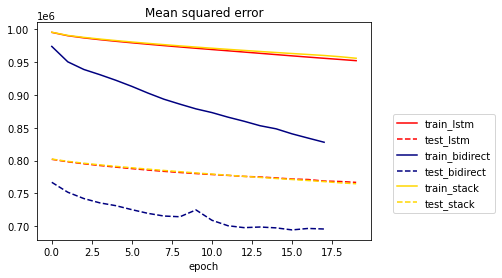

In [75]:
plt.title('Mean squared error')
plt.xlabel('epoch')
plt.plot(history1a.history['mean_squared_error'], label='train_lstm', color = "red")
plt.plot(history1a.history['val_mean_squared_error'], label='test_lstm', linestyle='--', color = "red")
plt.plot(history2a.history['mean_squared_error'], label='train_bidirect', color = "navy")
plt.plot(history2a.history['val_mean_squared_error'], label='test_bidirect', linestyle='--', color = "navy")
plt.plot(history3a.history['mean_squared_error'], label='train_stack', color = "gold")
plt.plot(history3a.history['val_mean_squared_error'], label='test_stack', linestyle='--', color = "gold")
plt.legend(bbox_to_anchor = (1.05, 0.6))
plt.show()



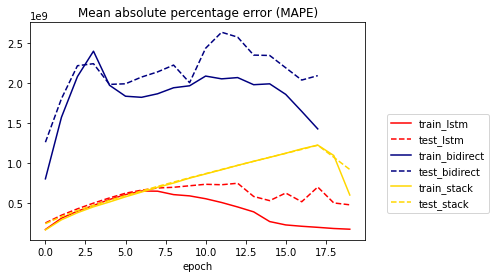

In [74]:
plt.title('Mean absolute percentage error (MAPE)')
plt.xlabel('epoch')
plt.plot(history1a.history['mean_absolute_percentage_error'], label='train_lstm', color = "red")
plt.plot(history1a.history['val_mean_absolute_percentage_error'], label='test_lstm', linestyle='--', color = "red")
plt.plot(history2a.history['mean_absolute_percentage_error'], label='train_bidirect', color = "navy")
plt.plot(history2a.history['val_mean_absolute_percentage_error'], label='test_bidirect', linestyle='--', color = "navy")
plt.plot(history3a.history['mean_absolute_percentage_error'], label='train_stack', color = "gold")
plt.plot(history3a.history['val_mean_absolute_percentage_error'], label='test_stack', linestyle='--', color = "gold")
plt.legend(bbox_to_anchor = (1.05, 0.6))
plt.show()

In [84]:
history2a.history['mean_squared_error'][-1]

828027.25

In [88]:
#Train a linear regression model with the non-text features to compare with the results of LSTM models

from sklearn.linear_model import LinearRegression
from sklearn import metrics

X0 = df[["clicksCount", "orderNum", "originalFlag"]]
Y2 = df['likeCount'].values



X0_train, X0_test, Y2_train, Y2_test = train_test_split(X,Y2, test_size = 0.20, random_state = 42)


lr = LinearRegression()
lr.fit(X0_train, Y2_train)
y_pred = lr.predict(X0_test)

mse_lr=metrics.mean_squared_error(Y2_test, y_pred)
mape_lr = metrics.mean_absolute_percentage_error(Y2_test, y_pred)

print("LR MSE: %f" % (mse_lr))




LR MSE: 1010437.907273


In [136]:
from sklearn.svm import SVC

from sklearn.preprocessing import MinMaxScaler

X0 = df[["clicksCount", "orderNum", "originalFlag"]]
Y2 = df['advertisement']


X0_train, X0_test, Y2_train, Y2_test = train_test_split(X0,Y2, test_size = 0.20, random_state = 42)

scaling = MinMaxScaler(feature_range=(-1,1)).fit(X0_train)
X0_train = scaling.transform(X0_train)
X0_test = scaling.transform(X0_test)

regressor= SVC(kernel='linear')
regressor.fit(X0_train,Y2_train)
y_pred_svm=regressor.predict(X0_test)
#y_pred_svm = cross_val_predict(regressor, x, y)

svm_mse=metrics.accuracy_score(Y2_test, y_pred_svm)
print("SVM accuracy: %f" % (svm_mse))



SVM accuracy: 0.669835
